In [7]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Output folder
os.makedirs("final_outputs", exist_ok=True)

Device: cpu


# 1)Load Clean Data

Data shape: (25260, 69)
X shape: (25260, 67)
y unique: [1 0]
Numeric cols: 67 Categorical cols: 0
   class  count    percent
0      0   9951  39.394299
1      1  15309  60.605701


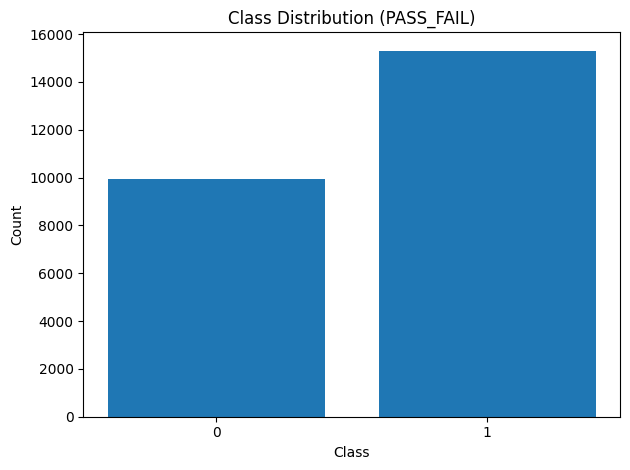

In [8]:
df = pd.read_csv("processed_clean_data.csv")

target_col = "TARGET" if "TARGET" in df.columns else ("NP_TARGET" if "NP_TARGET" in df.columns else None)
if target_col is None:
    print("Warning: TARGET/NP_TARGET not found. Proceeding without dropping it.")

# TARGET and PASS_FAIL
if "PASS_FAIL" not in df.columns:
    raise ValueError("PASS_FAIL column not found in the dataset.")

drop_cols = ["PASS_FAIL"]
if target_col is not None:
    drop_cols.append(target_col)

X_raw = df.drop(columns=drop_cols, errors="ignore")
y_raw = df["PASS_FAIL"].copy()

print("Data shape:", df.shape)
print("X shape:", X_raw.shape)
print("y unique:", y_raw.unique()[:20])

# Detect categorical columns if any
cat_cols = X_raw.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X_raw.columns if c not in cat_cols]
print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

# If categorical exists, you need encoding. For now we enforce numeric-only.
if len(cat_cols) > 0:
    raise ValueError(
        f"Categorical columns detected ({len(cat_cols)}). "
        "Encode them (OneHot/TargetEncoding) before running this notebook."
    )

# Class distribution
y = y_raw.values
classes, counts = np.unique(y, return_counts=True)
dist = pd.DataFrame({"class": classes, "count": counts, "percent": counts / counts.sum() * 100})
print(dist)

plt.figure()
plt.bar(dist["class"].astype(str), dist["count"])
plt.title("Class Distribution (PASS_FAIL)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2)Train/Val/Test Split (Leakage-safe)

In [9]:
# Binary recommended. If multi-class exists, code still runs but ROC handling changes.

X = X_raw.values.astype(np.float32)

# Stratified split: Train 70%, Temp 30% then Val 15% Test 15%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

def show_split_dist(name, yv):
    cls, cnt = np.unique(yv, return_counts=True)
    d = pd.DataFrame({"class": cls, "count": cnt, "percent": cnt/cnt.sum()*100})
    print(f"\n{name} distribution:\n", d)

show_split_dist("Train", y_train)
show_split_dist("Val", y_val)
show_split_dist("Test", y_test)

Train: (17682, 67) Val: (3789, 67) Test: (3789, 67)

Train distribution:
    class  count    percent
0      0   6966  39.395996
1      1  10716  60.604004

Val distribution:
    class  count    percent
0      0   1492  39.377144
1      1   2297  60.622856

Test distribution:
    class  count    percent
0      0   1493  39.403537
1      1   2296  60.596463


# 3)Preprocessing (Imputation) - fitted on TRAIN only

In [10]:
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

# Helpers
is_binary = (len(np.unique(y_train)) == 2)
print("Binary classification:", is_binary)

Binary classification: True


# 4)Feature Selection — Chi-Square + Mutual Information

In [11]:
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train_imp)
X_val_mm   = scaler_mm.transform(X_val_imp)
X_test_mm  = scaler_mm.transform(X_test_imp)



In [12]:
K_CHI = 20  # change if needed
selector_chi = SelectKBest(chi2, k=min(K_CHI, X_train_mm.shape[1]))
X_train_chi = selector_chi.fit_transform(X_train_mm, y_train)
X_val_chi   = selector_chi.transform(X_val_mm)
X_test_chi  = selector_chi.transform(X_test_mm)

In [13]:
chi_support = selector_chi.get_support(indices=True)
chi_features = X_raw.columns[chi_support].tolist()
print("Chi2 selected features (top k):", len(chi_features))
print(chi_features[:30])


Chi2 selected features (top k): 20
['ACCOMPLISH_MANDATORY', 'ACCOMPLISH_MANDATORY_GRADE', 'ACCOMPLISH_MANDATORY_PCT_GRADED', 'ACCOMPLISH_MANDATORY_PERCENTILE_GRADE', 'NP_ACCOMPLISH_MANDATORY_GRADE', 'NP_TARGET', 'COURSE_VIEW_TIME_1', 'RESOURCE_VIEW_UNIQUE_PCT', 'URL_VIEW_TIME_4', 'URL_VIEW_UNIQUE_PCT', 'ASSIGN_VIEW_UNIQUE_PCT', 'QUIZ_VIEW_UNIQUE_PCT', 'ASSIGN_SUBMIT_TIME_PCT', 'ASSIGN_SUBMIT_UNIQUE_PCT', 'QUIZ_ATTEMPT_TIME_PCT', 'QUIZ_ATTEMPT_UNIQUE_PCT', 'QUIZ_CLOSE_ATTEMPT_TIME_2', 'QUIZ_CLOSE_ATTEMPT_TIME_3', 'QUIZ_CLOSE_ATTEMPT_TIME_PCT', 'QUIZ_CLOSE_ATTEMPT_UNIQUE_PCT']


In [14]:
mi_scores = mutual_info_classif(X_train_imp, y_train, random_state=SEED)
mi_df = pd.DataFrame({"Feature": X_raw.columns, "MI": mi_scores}).sort_values("MI", ascending=False)
top_mi = mi_df.head(20)
top_mi

,Feature,MI
11,NP_TARGET,0.489389
2,ACCOMPLISH_MANDATORY_GRADE,0.357144
9,NP_ACCOMPLISH_MANDATORY_GRADE,0.285194
0,Unnamed: 0,0.230129
4,ACCOMPLISH_MANDATORY_PERCENTILE_GRADE,0.206133
47,ASSIGN_SUBMIT_PCT,0.104789
35,ASSIGN_VIEW_PCT,0.095414
12,COURSE_VIEW_PCT,0.093659
19,RESOURCE_VIEW_PCT,0.085109
3,ACCOMPLISH_MANDATORY_PCT_GRADED,0.079175


## 5)PCA (Boyut İndirgeme)

In [15]:
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train_imp)
X_val_std   = scaler_std.transform(X_val_imp)
X_test_std  = scaler_std.transform(X_test_imp)

pca = PCA(n_components=0.95, random_state=SEED)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca   = pca.transform(X_val_std)
X_test_pca  = pca.transform(X_test_std)

print("Original dim:", X_train.shape[1])
print("PCA dim:", X_train_pca.shape[1])
print("Explained variance sum:", float(pca.explained_variance_ratio_.sum()))


Original dim: 67
PCA dim: 37
Explained variance sum: 0.9500241875648499


# 6) Metrics + ROC helpers

In [16]:
def compute_metrics(y_true, y_pred, y_prob=None, average="binary"):
    out = {}
    out["accuracy"] = accuracy_score(y_true, y_pred)

    # balanced accuracy only meaningful when >1 class
    out["balanced_accuracy"] = balanced_accuracy_score(y_true, y_pred)

    out["precision"] = precision_score(y_true, y_pred, average=average, zero_division=0)
    out["recall"]    = recall_score(y_true, y_pred, average=average, zero_division=0)
    out["f1"]        = f1_score(y_true, y_pred, average=average, zero_division=0)

    # AUC
    if y_prob is not None:
        # Binary AUC expects probability for positive class
        if len(np.unique(y_true)) == 2:
            out["auc"] = roc_auc_score(y_true, y_prob)
        else:
            # Multiclass: expect y_prob shape (n, n_classes)
            out["auc"] = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
    else:
        out["auc"] = np.nan

    return out

def plot_roc_binary(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    aucv = roc_auc_score(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={aucv:.4f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

def save_classification_report(y_true, y_pred, path_txt):
    rep = classification_report(y_true, y_pred, zero_division=0)
    with open(path_txt, "w", encoding="utf-8") as f:
        f.write(rep)
    return rep

# Store results
results = []

# 7) Base Models (SVM + LDA) with full metrics + ROC

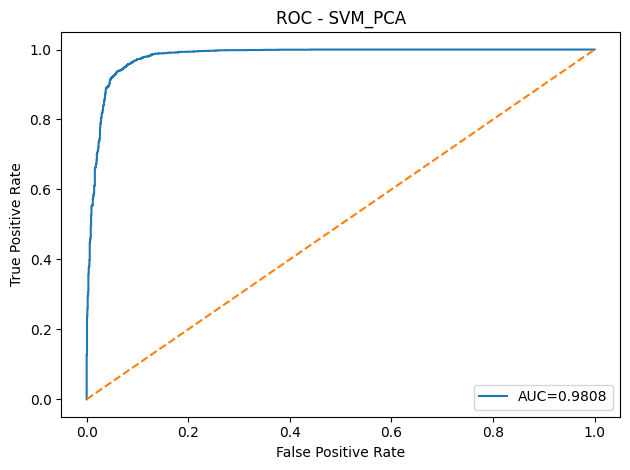

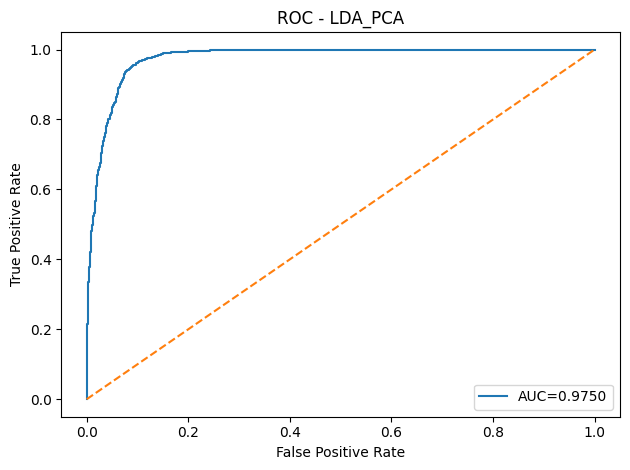

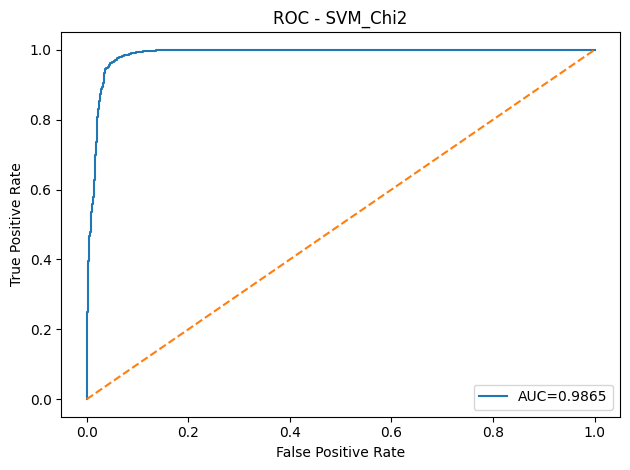

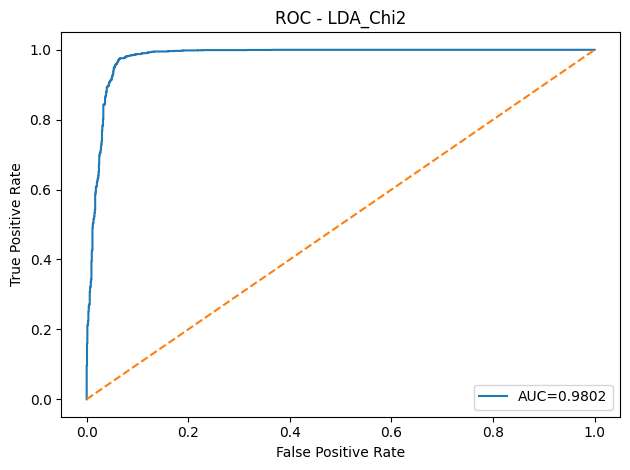

,Model,accuracy,balanced_accuracy,precision,recall,f1,auc
2,SVM_Chi2,0.960676,0.954317,0.952381,0.984321,0.968087,0.986536
3,LDA_Chi2,0.952758,0.943333,0.937578,0.987805,0.962036,0.980165
0,SVM_PCA,0.942729,0.933184,0.930792,0.978223,0.953918,0.980764
1,LDA_PCA,0.936131,0.925514,0.923331,0.975610,0.948751,0.975050


In [17]:
def eval_sklearn_model(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    # Probabilities for AUC/ROC
    y_prob = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(Xte)
        if proba.shape[1] == 2:
            y_prob = proba[:, 1]
        else:
            y_prob = proba
    elif hasattr(model, "decision_function"):
        dec = model.decision_function(Xte)
        # decision_function can be (n,) for binary
        if dec.ndim == 1:
            # map to [0,1] via sigmoid for ROC/AUC compatibility
            y_prob = 1 / (1 + np.exp(-dec))
        else:
            y_prob = dec

    avg = "binary" if len(np.unique(ytr)) == 2 else "macro"
    met = compute_metrics(yte, pred, y_prob=y_prob, average=avg)

    # Save reports
    save_classification_report(yte, pred, f"final_outputs/{name}_classification_report.txt")

    # ROC
    if y_prob is not None and len(np.unique(yte)) == 2:
        plot_roc_binary(yte, y_prob, f"ROC - {name}")

    results.append({
        "Model": name,
        **met
    })

# Base models
svm = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=SEED)
lda = LinearDiscriminantAnalysis()

# Evaluate on PCA features (example)
eval_sklearn_model("SVM_PCA", svm, X_train_pca, y_train, X_test_pca, y_test)
eval_sklearn_model("LDA_PCA", lda, X_train_pca, y_train, X_test_pca, y_test)

# Evaluate on Chi2 features (example)
eval_sklearn_model("SVM_Chi2", svm, X_train_chi, y_train, X_test_chi, y_test)
eval_sklearn_model("LDA_Chi2", lda, X_train_chi, y_train, X_test_chi, y_test)

pd.DataFrame(results).sort_values("f1", ascending=False)

# 8) PyTorch Data Utilities

In [18]:
class TabDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def make_loaders(Xtr, ytr, Xva, yva, batch_size=256):
    train_ds = TabDataset(Xtr, ytr)
    val_ds   = TabDataset(Xva, yva)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    return train_loader, val_loader

def predict_proba_binary(model, X_np, batch_size=512):
    model.eval()
    ds = torch.tensor(X_np, dtype=torch.float32)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    probs = []
    with torch.no_grad():
        for xb in loader:
            xb = xb.to(device)
            logits = model(xb)
            p = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
            probs.append(p)
    return np.concatenate(probs, axis=0)

def train_classifier_binary(
    model, train_loader, val_loader,
    lr=1e-3, weight_decay=0.0, epochs=50,
    patience=10
):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_state = None
    best_val = -np.inf
    bad = 0

    for ep in range(1, epochs+1):
        model.train()
        tr_losses = []

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).float()

            optimizer.zero_grad()
            logits = model(xb).view(-1)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            tr_losses.append(loss.item())

        # Val AUC
        yv_true = []
        yv_prob = []
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb).view(-1)
                prob = torch.sigmoid(logits).detach().cpu().numpy()
                yv_prob.append(prob)
                yv_true.append(yb.numpy())

        yv_true = np.concatenate(yv_true).astype(int)
        yv_prob = np.concatenate(yv_prob)

        # If val has both classes
        if len(np.unique(yv_true)) == 2:
            val_auc = roc_auc_score(yv_true, yv_prob)
        else:
            val_auc = -np.inf

        if val_auc > best_val:
            best_val = val_auc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return best_val

# 9) Advanced Model 1: Deep Autoencoder + Classifier

In [19]:
class DeepAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32, hidden_dims=(256, 128, 64), dropout=0.1):
        super().__init__()
        # Encoder
        enc_layers = []
        prev = input_dim
        for h in hidden_dims:
            enc_layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        enc_layers += [nn.Linear(prev, latent_dim)]
        self.encoder = nn.Sequential(*enc_layers)

        # Decoder (mirror)
        dec_layers = []
        prev = latent_dim
        for h in reversed(hidden_dims):
            dec_layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        dec_layers += [nn.Linear(prev, input_dim)]
        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat

class AEClassifier(nn.Module):
    def __init__(self, encoder: nn.Module, latent_dim=32, head_hidden=(64, 32), dropout=0.1):
        super().__init__()
        self.encoder = encoder
        layers = []
        prev = latent_dim
        for h in head_hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]  # binary logits
        self.head = nn.Sequential(*layers)

    def forward(self, x):
        z = self.encoder(x)
        logits = self.head(z).view(-1)
        return logits

def train_autoencoder(ae, Xtr, Xva, lr=1e-3, weight_decay=0.0, epochs=100, batch_size=256, patience=15):
    ae = ae.to(device)
    opt = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=weight_decay)
    crit = nn.MSELoss()

    tr_loader = DataLoader(torch.tensor(Xtr, dtype=torch.float32), batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(torch.tensor(Xva, dtype=torch.float32), batch_size=batch_size, shuffle=False)

    best_state = None
    best_val = np.inf
    bad = 0

    for ep in range(1, epochs+1):
        ae.train()
        for xb in tr_loader:
            xb = xb.to(device)
            opt.zero_grad()
            xhat = ae(xb)
            loss = crit(xhat, xb)
            loss.backward()
            opt.step()

        # val
        ae.eval()
        losses = []
        with torch.no_grad():
            for xb in va_loader:
                xb = xb.to(device)
                xhat = ae(xb)
                loss = crit(xhat, xb).item()
                losses.append(loss)
        val_loss = float(np.mean(losses))

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in ae.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        ae.load_state_dict(best_state)

    return ae, best_val

# 10) Advanced Model 2: Wide & Deep Network

In [20]:
class WideDeep(nn.Module):
    def __init__(self, input_dim, deep_hidden=(256, 128), dropout=0.1):
        super().__init__()
        # Wide part
        self.wide = nn.Linear(input_dim, 1)

        # Deep part
        layers = []
        prev = input_dim
        for h in deep_hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.deep = nn.Sequential(*layers)

    def forward(self, x):
        wide_logits = self.wide(x).view(-1)
        deep_logits = self.deep(x).view(-1)
        return wide_logits + deep_logits  # final logits

# 11) Prepare Inputs for PyTorch

In [21]:
Xtr_nn = X_train_std.astype(np.float32)
Xva_nn = X_val_std.astype(np.float32)
Xte_nn = X_test_std.astype(np.float32)

# Enforce binary for these two advanced models
if len(np.unique(y_train)) != 2:
    raise ValueError("These PyTorch models are written for binary classification only (PASS_FAIL must have 2 classes).")

ytr_nn = y_train.astype(int)
yva_nn = y_val.astype(int)
yte_nn = y_test.astype(int)

print("NN input dim:", Xtr_nn.shape[1])

NN input dim: 67


# 12) Hyperparameter Tuning (lightweight) - Advanced Model 1 (AE + Classifier)

In [22]:
input_dim = Xtr_nn.shape[1]

# Tuning grids (keep small for runtime)
ae_grid = [
    {"latent_dim": 16, "dropout": 0.1, "ae_lr": 1e-3, "clf_lr": 1e-3, "batch_size": 256},
    {"latent_dim": 32, "dropout": 0.1, "ae_lr": 1e-3, "clf_lr": 1e-3, "batch_size": 256},
    {"latent_dim": 32, "dropout": 0.2, "ae_lr": 5e-4, "clf_lr": 1e-3, "batch_size": 256},
]

best_cfg_ae = None
best_val_auc_ae = -np.inf
best_model_ae = None

for cfg in ae_grid:
    set_seed(SEED)

    # Train autoencoder unsupervised on train, validate on val
    ae = DeepAutoencoder(
        input_dim=input_dim,
        latent_dim=cfg["latent_dim"],
        hidden_dims=(256, 128, 64),
        dropout=cfg["dropout"]
    )
    ae, best_ae_val = train_autoencoder(
        ae, Xtr_nn, Xva_nn,
        lr=cfg["ae_lr"],
        epochs=120,
        batch_size=cfg["batch_size"],
        patience=15
    )

    # Build classifier on encoder
    clf = AEClassifier(
        encoder=ae.encoder,
        latent_dim=cfg["latent_dim"],
        head_hidden=(64, 32),
        dropout=cfg["dropout"]
    ).to(device)

    train_loader, val_loader = make_loaders(Xtr_nn, ytr_nn, Xva_nn, yva_nn, batch_size=cfg["batch_size"])
    val_auc = train_classifier_binary(
        clf, train_loader, val_loader,
        lr=cfg["clf_lr"],
        epochs=80,
        patience=10
    )

    if val_auc > best_val_auc_ae:
        best_val_auc_ae = val_auc
        best_cfg_ae = cfg
        best_model_ae = clf

print("Best AE+CLF cfg:", best_cfg_ae)
print("Best AE+CLF val AUC:", best_val_auc_ae)

Best AE+CLF cfg: {'latent_dim': 32, 'dropout': 0.2, 'ae_lr': 0.0005, 'clf_lr': 0.001, 'batch_size': 256}
Best AE+CLF val AUC: 0.9891303903798053


# 13) Evaluate Advanced Model 1 on TEST (metrics + ROC + reports)

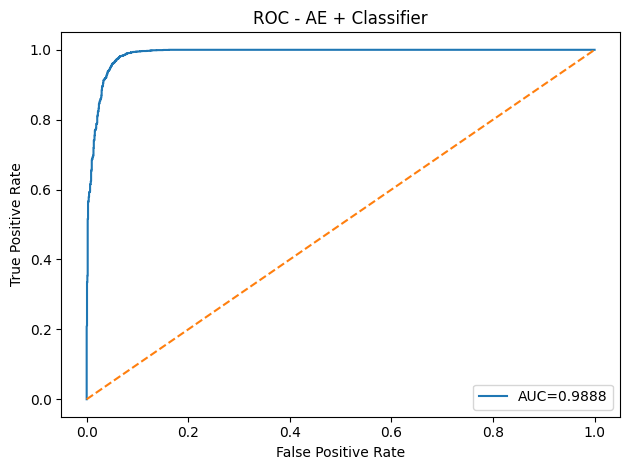

,Model,accuracy,balanced_accuracy,precision,recall,f1,auc
2,SVM_Chi2,0.960676,0.954317,0.952381,0.984321,0.968087,0.986536
4,AE_Classifier,0.957772,0.955552,0.964348,0.966028,0.965187,0.988756
3,LDA_Chi2,0.952758,0.943333,0.937578,0.987805,0.962036,0.980165
0,SVM_PCA,0.942729,0.933184,0.930792,0.978223,0.953918,0.980764
1,LDA_PCA,0.936131,0.925514,0.923331,0.975610,0.948751,0.975050


In [23]:
y_prob = predict_proba_binary(best_model_ae, Xte_nn)
y_pred = (y_prob >= 0.5).astype(int)

met = compute_metrics(yte_nn, y_pred, y_prob=y_prob, average="binary")
results.append({"Model": "AE_Classifier", **met})

# Save report
save_classification_report(yte_nn, y_pred, "final_outputs/AE_Classifier_classification_report.txt")

# ROC
plot_roc_binary(yte_nn, y_prob, "ROC - AE + Classifier")
pd.DataFrame(results).sort_values("f1", ascending=False)

# 14) Hyperparameter Tuning - Advanced Model 2 (Wide & Deep)

In [24]:
wd_grid = [
    {"deep_hidden": (256, 128), "dropout": 0.1, "lr": 1e-3, "batch_size": 256, "weight_decay": 0.0},
    {"deep_hidden": (128, 64),  "dropout": 0.1, "lr": 1e-3, "batch_size": 256, "weight_decay": 1e-5},
    {"deep_hidden": (256, 128), "dropout": 0.2, "lr": 5e-4, "batch_size": 256, "weight_decay": 1e-5},
]

best_cfg_wd = None
best_val_auc_wd = -np.inf
best_model_wd = None

for cfg in wd_grid:
    set_seed(SEED)

    model = WideDeep(
        input_dim=input_dim,
        deep_hidden=cfg["deep_hidden"],
        dropout=cfg["dropout"]
    ).to(device)

    train_loader, val_loader = make_loaders(Xtr_nn, ytr_nn, Xva_nn, yva_nn, batch_size=cfg["batch_size"])
    val_auc = train_classifier_binary(
        model, train_loader, val_loader,
        lr=cfg["lr"],
        weight_decay=cfg["weight_decay"],
        epochs=120,
        patience=12
    )

    if val_auc > best_val_auc_wd:
        best_val_auc_wd = val_auc
        best_cfg_wd = cfg
        best_model_wd = model

print("Best Wide&Deep cfg:", best_cfg_wd)
print("Best Wide&Deep val AUC:", best_val_auc_wd)

Best Wide&Deep cfg: {'deep_hidden': (256, 128), 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 256, 'weight_decay': 1e-05}
Best Wide&Deep val AUC: 0.9892427294722922


# 15) Evaluate Advanced Model 2 on TEST (metrics + ROC + reports)

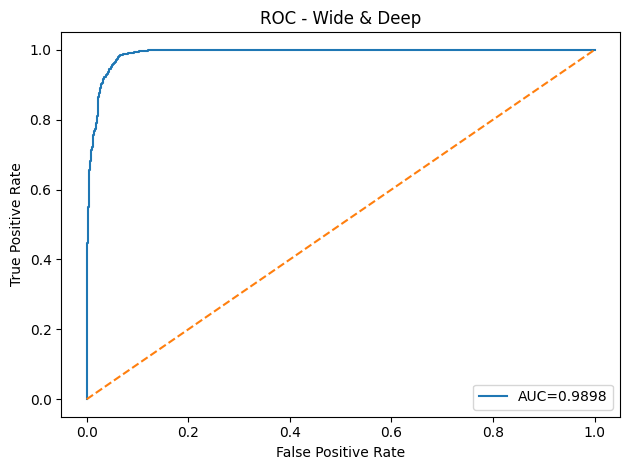

,Model,accuracy,balanced_accuracy,precision,recall,f1,auc
5,Wide_Deep,0.963843,0.958570,0.957997,0.983449,0.970557,0.989833
2,SVM_Chi2,0.960676,0.954317,0.952381,0.984321,0.968087,0.986536
4,AE_Classifier,0.957772,0.955552,0.964348,0.966028,0.965187,0.988756
3,LDA_Chi2,0.952758,0.943333,0.937578,0.987805,0.962036,0.980165
0,SVM_PCA,0.942729,0.933184,0.930792,0.978223,0.953918,0.980764
1,LDA_PCA,0.936131,0.925514,0.923331,0.975610,0.948751,0.975050


In [25]:
y_prob = predict_proba_binary(best_model_wd, Xte_nn)
y_pred = (y_prob >= 0.5).astype(int)

met = compute_metrics(yte_nn, y_pred, y_prob=y_prob, average="binary")
results.append({"Model": "Wide_Deep", **met})

save_classification_report(yte_nn, y_pred, "final_outputs/Wide_Deep_classification_report.txt")
plot_roc_binary(yte_nn, y_prob, "ROC - Wide & Deep")

pd.DataFrame(results).sort_values("f1", ascending=False)

# 16) Final Comparison Tables

In [26]:
df_results = pd.DataFrame(results)

# Keep a consistent column order
cols = ["Model", "accuracy", "balanced_accuracy", "precision", "recall", "f1", "auc"]
df_results = df_results[cols].sort_values("f1", ascending=False)

df_results.to_csv("final_outputs/final_overall_comparison.csv", index=False)
df_results

,Model,accuracy,balanced_accuracy,precision,recall,f1,auc
5,Wide_Deep,0.963843,0.958570,0.957997,0.983449,0.970557,0.989833
2,SVM_Chi2,0.960676,0.954317,0.952381,0.984321,0.968087,0.986536
4,AE_Classifier,0.957772,0.955552,0.964348,0.966028,0.965187,0.988756
3,LDA_Chi2,0.952758,0.943333,0.937578,0.987805,0.962036,0.980165
0,SVM_PCA,0.942729,0.933184,0.930792,0.978223,0.953918,0.980764
1,LDA_PCA,0.936131,0.925514,0.923331,0.975610,0.948751,0.975050


# 17) Class-wise Comparison Table (per model)

In [27]:
def classwise_table_sklearn(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    rep = classification_report(yte, pred, output_dict=True, zero_division=0)
    rows = []
    for k, v in rep.items():
        if k in ["accuracy", "macro avg", "weighted avg"]:
            continue
        # k is class label
        rows.append({
            "Model": name,
            "Class": k,
            "precision": v["precision"],
            "recall": v["recall"],
            "f1": v["f1-score"],
            "support": v["support"]
        })
    return pd.DataFrame(rows)

def classwise_table_pytorch(name, y_true, y_pred):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    rows = []
    for k, v in rep.items():
        if k in ["accuracy", "macro avg", "weighted avg"]:
            continue
        rows.append({
            "Model": name,
            "Class": k,
            "precision": v["precision"],
            "recall": v["recall"],
            "f1": v["f1-score"],
            "support": v["support"]
        })
    return pd.DataFrame(rows)

# Build class-wise table on TEST for all models
cw_all = []

# Base models on PCA
cw_all.append(classwise_table_sklearn("SVM_PCA", svm, X_train_pca, y_train, X_test_pca, y_test))
cw_all.append(classwise_table_sklearn("LDA_PCA", lda, X_train_pca, y_train, X_test_pca, y_test))

# Base models on Chi2
cw_all.append(classwise_table_sklearn("SVM_Chi2", svm, X_train_chi, y_train, X_test_chi, y_test))
cw_all.append(classwise_table_sklearn("LDA_Chi2", lda, X_train_chi, y_train, X_test_chi, y_test))

# Advanced models (we already have y_pred from last eval cell; recompute safely)
y_prob_ae = predict_proba_binary(best_model_ae, Xte_nn)
y_pred_ae = (y_prob_ae >= 0.5).astype(int)
cw_all.append(classwise_table_pytorch("AE_Classifier", yte_nn, y_pred_ae))

y_prob_wd = predict_proba_binary(best_model_wd, Xte_nn)
y_pred_wd = (y_prob_wd >= 0.5).astype(int)
cw_all.append(classwise_table_pytorch("Wide_Deep", yte_nn, y_pred_wd))

df_classwise = pd.concat(cw_all, ignore_index=True)
df_classwise.to_csv("final_outputs/final_classwise_comparison.csv", index=False)
df_classwise

,Model,Class,precision,recall,f1,support
0,SVM_PCA,0,0.963663,0.888145,0.924364,1493.0
1,SVM_PCA,1,0.930792,0.978223,0.953918,2296.0
2,LDA_PCA,0,0.958914,0.875419,0.915266,1493.0
3,LDA_PCA,1,0.923331,0.975610,0.948751,2296.0
4,SVM_Chi2,0,0.974576,0.924313,0.948780,1493.0
5,SVM_Chi2,1,0.952381,0.984321,0.968087,2296.0
6,LDA_Chi2,0,0.979562,0.898861,0.937478,1493.0
7,LDA_Chi2,1,0.937578,0.987805,0.962036,2296.0
8,AE_Classifier,0,0.947616,0.945077,0.946345,1493.0
9,AE_Classifier,1,0.964348,0.966028,0.965187,2296.0
